# Manticore-Local clusters

This notebook analyzes galaxy cluster data from the Manticore-Local cluster catalog. The analysis includes:

- Loading and parsing the fixed-width data file
- Plotting median M200 halo masses for each cluster with 10th-90th percentile error bars
- Examining the mass distribution for individual clusters

The data contains 80 measurements per cluster from MCMC posterior samples, allowing us to characterize the uncertainty in halo mass estimates.

**Data columns of interest:**
- `Name`: Cluster identifier
- `M200`: Halo mass within R200 (units: 10^14 solar masses)
- `SampleID`: MCMC posterior sample ID (0-79 for each cluster)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define column specifications based on the data file format
column_specs = [
    (0, 7),    # RAdeg
    (8, 15),   # DEdeg  
    (16, 23),  # Dist
    (24, 41),  # Name
    (42, 51),  # pval
    (52, 57),  # SepAng
    (58, 64),  # M200
    (65, 71),  # M500
    (72, 80),  # vpec
    (81, 90),  # vrec
    (91, 98),  # x
    (99, 106), # y
    (107, 114), # z
    (115, 117)  # SampleID
]

column_names = ['RAdeg', 'DEdeg', 'Dist', 'Name', 'pval', 'SepAng', 
                'M200', 'M500', 'vpec', 'vrec', 'x', 'y', 'z', 'SampleID']

# Read the fixed-width file
df = pd.read_fwf('manticore_local_clusters.dat', colspecs=column_specs, names=column_names)

# Clean cluster names by stripping whitespace
df['Name'] = df['Name'].str.strip()

print(f"Loaded {len(df)} measurements for {df['Name'].nunique()} clusters")
print(f"Sample of data:")
print(df.head(5))

Loaded 1119 measurements for 14 clusters
Sample of data:
    RAdeg  DEdeg     Dist       Name       pval  SepAng   M200   M500  \
0  13.739 -2.523  187.894  Abell 119  212.72555   1.349  1.067  0.759   
1  13.960 -0.931  182.744  Abell 119   24.55737   0.308  6.254  4.066   
2  14.038 -0.877  184.685  Abell 119    4.24110   0.342  8.709  5.992   
3  13.815 -1.442  185.120  Abell 119    7.45640   0.345  7.091  4.400   
4  13.827 -1.364  184.689  Abell 119    3.55661   0.290  9.265  5.809   

      vpec       vrec        x        y        z  SampleID  
0 -125.114  12670.452  682.340  544.583  491.728         1  
1  135.608  12580.504  677.323  544.081  497.031         2  
2  199.492  12776.548  679.149  544.792  497.174         3  
3   90.697  12697.348  679.707  544.191  495.342         4  
4  209.829  12787.130  679.286  544.125  495.603         5  


## Median mass distribution

Make a plot showing the median mass of each cluster (and 10 to 90 percentiles).

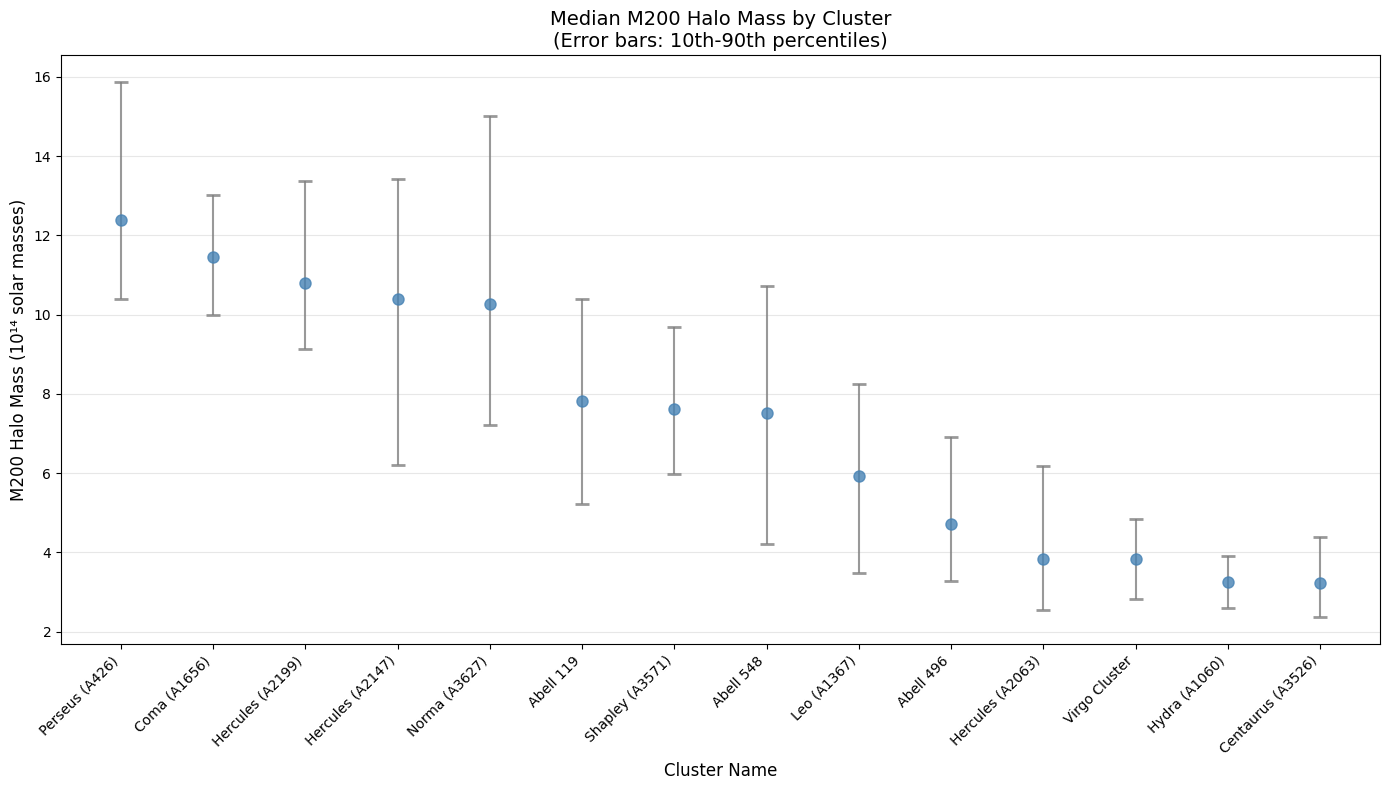

Mass range: 3.23 - 12.40 × 10¹⁴ M☉


In [2]:
# Calculate median and percentiles for each cluster
cluster_stats = df.groupby('Name')['M200'].agg(['median', 
                                                lambda x: np.percentile(x, 10),
                                                lambda x: np.percentile(x, 90)]).reset_index()
cluster_stats.columns = ['Name', 'median', 'p10', 'p90']

# Sort by median mass
cluster_stats = cluster_stats.sort_values('median', ascending=False)

# Create the scatter plot
plt.figure(figsize=(14, 8))

# Calculate error bars (distance from median to percentiles)
yerr_lower = cluster_stats['median'] - cluster_stats['p10']
yerr_upper = cluster_stats['p90'] - cluster_stats['median']

plt.errorbar(range(len(cluster_stats)), cluster_stats['median'], 
             yerr=[yerr_lower, yerr_upper], 
             fmt='o', capsize=5, capthick=2, markersize=8, 
             color='steelblue', ecolor='gray', alpha=0.8)

plt.xticks(range(len(cluster_stats)), cluster_stats['Name'], rotation=45, ha='right')
plt.xlabel('Cluster Name', fontsize=12)
plt.ylabel('M200 Halo Mass (10¹⁴ solar masses)', fontsize=12)
plt.title('Median M200 Halo Mass by Cluster\n(Error bars: 10th-90th percentiles)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Mass range: {cluster_stats['median'].min():.2f} - {cluster_stats['median'].max():.2f} × 10¹⁴ M☉")

## Posterior distributions of individual clusters

There are 80 entries per cluster, each a sample of the posterior. We can also plot the distribution of the posterior directly rather than simple medians and percentiles.

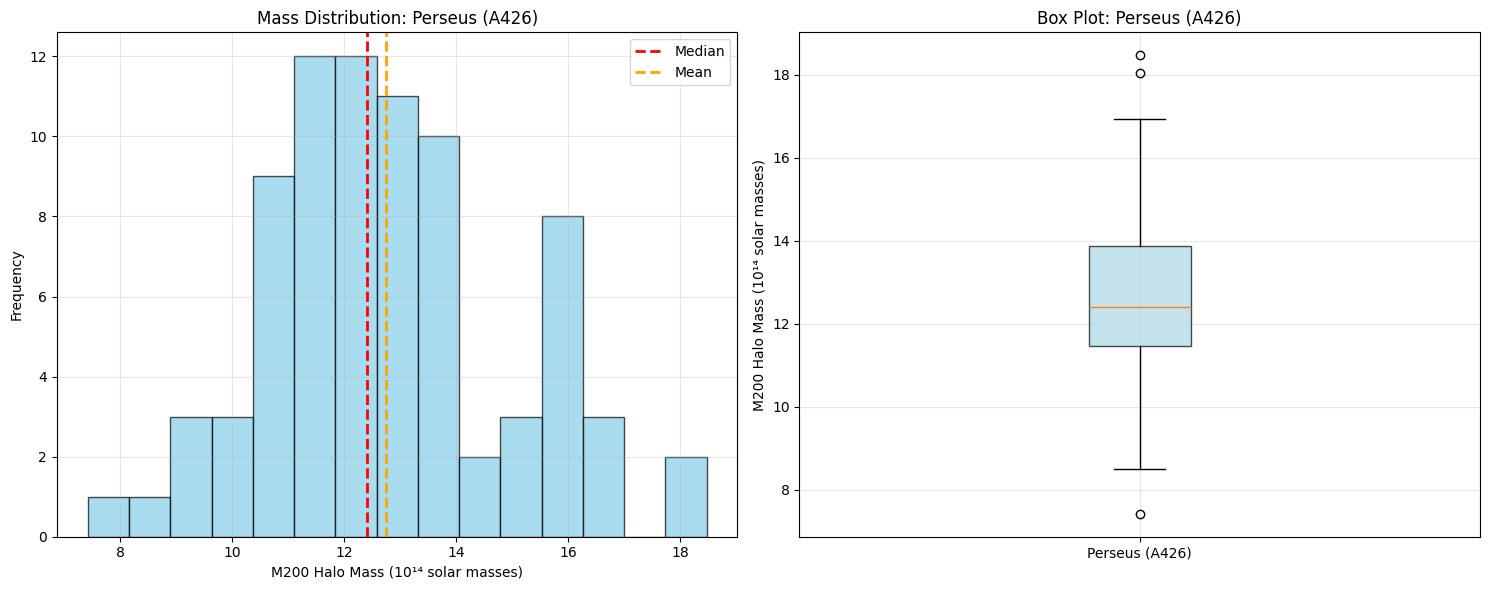

Statistics for Perseus (A426):
  Median: 12.398 × 10¹⁴ M☉
  Mean: 12.737 × 10¹⁴ M☉
  Std Dev: 2.211 × 10¹⁴ M☉
  10th percentile: 10.385 × 10¹⁴ M☉
  90th percentile: 15.868 × 10¹⁴ M☉
  Number of samples: 80

To examine a different cluster, change 'selected_cluster' to one of:
  ['Perseus (A426)', 'Coma (A1656)', 'Hercules (A2199)', 'Hercules (A2147)', 'Norma (A3627)']


In [3]:
# Select a cluster to examine (change this to explore different clusters)
selected_cluster = cluster_stats.iloc[0]['Name']  # Highest mass cluster by default

# Get all measurements for the selected cluster
cluster_data = df[df['Name'] == selected_cluster]['M200']

# Create histogram and statistics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram
ax1.hist(cluster_data, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(cluster_data.median(), color='red', linestyle='--', linewidth=2, label='Median')
ax1.axvline(cluster_data.mean(), color='orange', linestyle='--', linewidth=2, label='Mean')
ax1.set_xlabel('M200 Halo Mass (10¹⁴ solar masses)')
ax1.set_ylabel('Frequency')
ax1.set_title(f'Mass Distribution: {selected_cluster}')
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot
ax2.boxplot(cluster_data, vert=True, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', alpha=0.7))
ax2.set_ylabel('M200 Halo Mass (10¹⁴ solar masses)')
ax2.set_title(f'Box Plot: {selected_cluster}')
ax2.set_xticklabels([selected_cluster])
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Statistics for {selected_cluster}:")
print(f"  Median: {cluster_data.median():.3f} × 10¹⁴ M☉")
print(f"  Mean: {cluster_data.mean():.3f} × 10¹⁴ M☉")
print(f"  Std Dev: {cluster_data.std():.3f} × 10¹⁴ M☉")
print(f"  10th percentile: {np.percentile(cluster_data, 10):.3f} × 10¹⁴ M☉")
print(f"  90th percentile: {np.percentile(cluster_data, 90):.3f} × 10¹⁴ M☉")
print(f"  Number of samples: {len(cluster_data)}")

print(f"\nTo examine a different cluster, change 'selected_cluster' to one of:")
print(f"  {list(cluster_stats['Name'].head(5).values)}")  # Show top 5 options